# Piecewise Polytropic with ADM Example

To run this tutorial, you should install NEoST following the install guide.

Before continuing with this tutorial, please read the inference process overview to familiarise yourself with the way NEoST parametrises the equation of state.

The following block of code will properly import NEoST and its prerequisites, furthermore it also defines a name for the inference run, this name is what will be prefixed to all of NEoST's output files.

In [1]:
import neost
import kalepy
from neost.eos import polytropes
from neost.Prior import Prior
from neost.Star import Star
from neost.Likelihood import Likelihood
from neost import PosteriorAnalysis
from scipy.stats import multivariate_normal
from scipy.stats import gaussian_kde
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from pymultinest.solve import solve
import time
import os

import neost.global_imports as global_imports

# Some physical constants
c = global_imports._c
G = global_imports._G
Msun = global_imports._M_s
pi = global_imports._pi
rho_ns = global_imports._rhons

## Equation of state object
With NEoST properly imported the equation of state needs to be defined. For the PP parametrisation this is done by creating a `polytropes.PolytropicEoS()` object. This object takes as input the `crust` parameter, the `rho_t` parameter, `adm_type` string parameter, `dm_halo` boolean parameter, and `two_fluid_tidal` boolean parameter.

Valid input for the crust parameter consists of one of the following values: `'ceft-Hebeler'`, `'ceft-Tews'`, `'ceft-Lynn'`, `'ceft-Drischler'`, `'ceft-old'`, `'ceft-Keller-N2LO'`, `'ceft-Keller-N3LO'` or `None`. This instructs NEoST on which cEFT model to use, in order of listing these would be: the band based on the work by Hebeler et al., Tews et al., Lynn et al., Drischler et al., Keller et al. (2024), an old implementation of the Hebeler band from Raaijmakers et al., or no cEFT at all.

The `rho_t` parameter tells NEoST at which density to transition between the cEFT crust parametrisation and the core parametrisation. This value must not exceed a value of twice the nuclear saturation density, although for the currently implemented cEFT models it should not exceed 1.1 (1.5 for the Keller bands) times the nuclear saturation density.

The `adm_type` string parameter tells NEoST which ADM particle type to use from teh Ann Nelson et al. (2018) paper, namely a spin-0 boson or a spin-1/2 dirac fermion. This parameter is defaulted to `None`, so that it does not need to be defined in an analysis with only baryonic matter.

The `dm_halo` boolean parameter tells NEoST to calculate ADM halos (or not) when solving the two-fluid TOV equations in `TOVdm.pyx` or `TOVdm_python.py`. This parameter is defaulted to `False`, but we wanted to demonstrate where this value is set by the user. Thus, the inclusion of this parameter is only necessary if the user wishes to include ADM halos or not.  

The `two_fluid_tidal` boolean parameter tells NEoST to calculate the two-fluid tidalformability when solving the two-fluid TOV equations in `TOVdm.pyx` or `TOVdm_python.py`. This parameter is defaulted to `False`, but we wanted to demonstrate where this value is set by the user. Thus, the inclusion of this parameter is only necessary if the user wishes to calculate the tidal deformability of an ADM admixed neutron star.  


In [2]:
# Define name for run, extra - at the end is for nicer formatting of output
run_name = "PP-example-bosonic-adm-run"

# We're exploring a polytropic (PP) EoS parametrization with a chiral effective field theory (cEFT) parametrization based on Hebeler's work
# Transition between PP parametrisation and cEFT parametrization occurs at 1.1*saturation density
polytropes_pp = polytropes.PolytropicEoS(crust = 'ceft-Hebeler', rho_t = 1.1*rho_ns, adm_type = 'Bosonic',dm_halo = False,two_fluid_tidal = False)


This block of code defines the measurements used to create the likelihood function for the Bayesian analysis. It shows you how to define measurements for both SciPy and KalePy, as well as what parameters need to be past for a mass-radius measurement and for a gravitational wave event when using non-synthetic data. Note, this example does not include the gravitational waves event data, see the `PP_example' script for how to include it.

To define a mass-radius measurement you need to create a KDE object. For both KalePy and SciPy, you need to provide the samples from which to create the KDE. These samples need to be provided as an array of shape `(2,n)` where `n` is the number of samples of your dataset. The first row should consist of the masses and the second row should consist of the radii. As shown in the example, to turn a dataset into a SciPy KDE consists of simply calling the `gaussian_kde()` function and providing the dataset as argument.

To define a gravitational wave event you again have to create a KDE, again the format of the dataset is the same for both a KalePy and a SciPy KDE, but this time the array needs to have a shape of `(4,n)` where `n` again is the number of samples in your dataset. Here the rows correspond to the following quantities respectively:
- The chirp mass $M_c$
- The mass ratio $Q$
- The tidal deformability of the primary $\Lambda_1$
- The tidal deformability of the secondary $\Lambda_2$

For the purposes of this example script we now turn this dataset into a KalePy KDE. We do this by creating a `kalepy.KDE()` object which takes as first argument your dataset, as second argument you provide the reflection bounds of your KDE for each row in your dataset, where `None` indicates no reflection. The `weights` argument provides the weights of your dataset, if your dataset is equally-weighted you do not need to provide this argument. The `bandwidth` parameter allows you to tweak the width of the kernels in your KDE and the `kernel` argument allows you to specify which kernel you want to use.

Next, these KDEs need to be passed to NEoST, this is done through the `likelihood_functions` and `likelihood_params` lists. The first one is a list of all the (callable) KDEs, and the second one is a list of as many instances of `['Mass', 'Radius']` as you have mass-radius measurements. The ordering of this list matters insofar as that you need to put any mass-radius measurements first in the `likelihood_functions` list and any gravitational wave events second.

You will also need to define a `chirp_mass` list containing the median values of the chirp masses of your events, in case your event is a mass-radius measurement, enter `None` instead.

Finally you will also need to define how many events you pass to NEoST, a quick and easy way to do this is shown in the example code below.

This block also sets the `variable_params` depending on the `adm_type` value since the physical prior spaces of bosonic and fermionic ADM differ by virtue of their differing physical natures. Regardless of the `adm_type`, bot have three parameters: `mchi` the ADM particle mass in units of MeV, `gchi_over_mphi` the effective ADM self-repulsion strength in units of 1/MeV, and `adm_fraction` is the ADM mass-fraction defined at M_chi/M_total*100, where M_chi is the total accumulated ADM gravitational mass and M_total is the sum of M_chi and the total baryonic gravitational mass. 

With our data defined, the next step is to define both the prior and the likelihood function.

The prior is defined through a pair of dictionaries, `variable_params` and `static_params`. Here `variable_params` takes in the equation of state parameters that will be allowed to vary, and `static_params` will take in those that won't. Entries into `variable_params` should be formatted as follows: `'param_name':[lower_bound,upper_bound]`

Additionally, for each of the measurements you must also append a dictionary item `'rhoc_i':[14.6, 16]` to the end of `variable_params`, this parameter covers the central density of star i and needs to be appended for each star individually. Entries into `static_params` should be formatted in the following manner: `'param_name':value`.

In [3]:
# Create the likelihoods for the individual measurements
# First we load the mass-radius measurement
mass_radius_j0740 = np.load('j0740.npy').T
J0740_LL = gaussian_kde(mass_radius_j0740)


# Pass the likelihoods to the solver
likelihood_functions = [J0740_LL]
likelihood_params = [['Mass', 'Radius']]

# Define whether event is GW or not and define number of stars/events
chirp_mass = [None]
number_stars = len(chirp_mass)

# Define variable parameters, same prior as previous papers of Raaijmakers et al.
if polytropes_pp.adm_type == 'Bosonic':
    variable_params={'ceft':[polytropes_pp.min_norm, polytropes_pp.max_norm],'gamma1':[1.,4.5],'gamma2':[0.,8.],'gamma3':[0.5,8.],'rho_t1':[1.5,8.3],'rho_t2':[1.5,8.3],
                    'mchi':[-2, 8],'gchi_over_mphi': [-3,3],'adm_fraction':[0., 5.]}
elif polytropes_pp.adm_type == 'Fermionic':
    variable_params={'ceft':[polytropes_pp.min_norm, polytropes_pp.max_norm],'gamma1':[1.,4.5],'gamma2':[0.,8.],'gamma3':[0.5,8.],'rho_t1':[1.5,8.3],'rho_t2':[1.5,8.3],
                    'mchi':[-2, 9],'gchi_over_mphi': [-5,3],'adm_fraction':[0., 5.]}

else:
    variable_params={'ceft':[polytropes_pp.min_norm, polytropes_pp.max_norm],'gamma1':[1.,4.5],'gamma2':[0.,8.],'gamma3':[0.5,8.],'rho_t1':[1.5,8.3],'rho_t2':[1.5,8.3]}

#Note if the user wants to have a seperate adm_fraction per source, include it below via
#'adm_fraction_' + str(i+1):[0., 5.]. And eliminate the adm_fraction above, as that is to assume all Neutron stars have the same amount of adm_fraction
for i in range(number_stars):
	variable_params.update({'rhoc_' + str(i+1):[14.6, 16]})

# Define static parameters, empty dict because all params are variable 
static_params={}


If instead you are using synthetic data, for example a 2-dimensional Gaussian distribution, you can define a function that calculates the likelihood directly and pass this on to NEoST as follows:
```python
# 2-dimensional approximation of the J0740 measurement
mu_M = 2.08
mu_R = 11.155
sigma_M = 0.07 
sigma_R = 0.1 # uncertainty in radius
J0740 = sps.multivariate_normal(mean=[muM, muR], cov=[[sigM, 0.0], [0.0, sigR]])

likelihood_functions = [J0740.pdf]
likelihood_params = [['Mass', 'Radius']]
```

Finally, the prior object must be created using the following function call:`neost.Prior.Prior(EOS, variable_params, static_params, chirp_masses)` where the `EOS` argument is the equation of state object that was created in the previous step. When this prior is called it will then uniformly sample sets of parameters from the defined parameter ranges.

The likelihood is defined by providing both the previously defined prior object and the likelihood functions defined in the previous codeblock. This is done with the following code: `likelihood = Likelihood(prior, likelihood_functions, likelihood_params, chirp_mass)`

After defining your prior and likelihood function, it is best practice to test your prior and likelihood function. This is done with the short loop in the code block below. This loop will for each iteration first take a sample from the prior, and then compute the corresponding likelihood of said prior sample and print the likelihood as output.

In [4]:
# Define joint prior and joint likelihood
prior = Prior(polytropes_pp, variable_params, static_params, chirp_mass)
likelihood = Likelihood(prior, likelihood_functions, likelihood_params, chirp_mass)

print("Bounds of prior are")
print(variable_params)
print("number of parameters is %d" %len(variable_params))

# Perform a test, this will draw 50 random points from the prior and calculate their likelihood
print("Testing prior and likelihood")
cube = np.random.rand(50, len(variable_params))
for i in range(len(cube)):
    par = prior.inverse_sample(cube[i])
    print(likelihood.call(par))
print("Testing done")

Bounds of prior are
{'ceft': [1.676, 2.814], 'gamma1': [1.0, 4.5], 'gamma2': [0.0, 8.0], 'gamma3': [0.5, 8.0], 'rho_t1': [1.5, 8.3], 'rho_t2': [1.5, 8.3], 'mchi': [-2, 8], 'gchi_over_mphi': [-3, 3], 'adm_fraction': [0.0, 5.0], 'rhoc_1': [14.6, 16]}
number of parameters is 10
Testing prior and likelihood
-1e+101
-1e+101
-5.586192006851401
-2.15046905181244
-1e+101
-1e+101
-1e+101
-1e+101
-1e+101
-1e+101
-1e+101
-1e+101
-1e+101
-1e+101
-1e+101
-1e+101
-1e+101
-1e+101
-1e+101
-1e+101
-1e+101
-1e+101
-1e+101
-1e+101
-1e+101
-1e+101
-1e+101
-1e+101
-1e+101
-1e+101
-1e+101
-1e+101
-1e+101
-1e+101
-298.2966335727845
-1e+101
-282.45082963119773
-1e+101
-1e+101
-1e+101
-1e+101
-1e+101
-1e+101
-1e+101
-1e+101
-1e+101
-1e+101
-1e+101
-1e+101
-1e+101
Testing done


When finished with testing your likelihood and prior you can proceed to the actual inference process. This is done in the code block below. Warning: depending on the performance of your platform, this might be a very slow process. To make it slightly faster, we have decreased the number of live points and set a maximum number of iterations for this example. For a proper analysis, we would remove the max_iter argument and set, for example, n_live_points=2000-3000.

In [5]:
# Then we start the sampling with MultiNest
start = time.time()
result = solve(LogLikelihood=likelihood.call, Prior=prior.inverse_sample, n_live_points=250, evidence_tolerance=0.1,
               n_dims=len(variable_params), sampling_efficiency=0.8, outputfiles_basename='chains/' + run_name, verbose=True, resume=False)
end = time.time()
print(end - start)


 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  250
 dimensionality =   10
 *****************************************************
 Starting MultiNest
 generating live points
 live points generated, starting sampling
Acceptance Rate:                        0.983607
Replacements:                                300
Total Samples:                               305
Nested Sampling ln(Z):               -342.158855
Importance Nested Sampling ln(Z):      -1.275092 +/-  0.110442
Acceptance Rate:                        0.918635
Replacements:                                350
Total Samples:                               381
Nested Sampling ln(Z):               -139.333894
Importance Nested Sampling ln(Z):      -1.257231 +/-  0.098952
Acceptance Rate:                        0.757576
Replacements:                                400
Total Samples:                               528
Nested Sampling

Finally, NEoST also includes functionality to perform the first steps of posterior analysis. The first step in this process is to call the `PosteriorAnalysis.compute_auxiliary_data()` function with the code block below. This function also has a `dm` boolean parameter (default `dm = False`) that will compute the ADM admixed data. Note, if one wishes to compute the effect of ADM on the baryonic EoS posterior simply follow everything above, but set `dm = False`. This will generate as output a set of files that can subsequently be used with several additional plotting routines included in NEoST, or you can analyse these files on your own. For the following posterior analysis examples we use previously computed high-resolution MultiNest example outputs to avoid problems with too few samples. Note that computing the auxiliary data might take some time.

In [5]:
# Compute auxiliary data for posterior analysis
PosteriorAnalysis.compute_auxiliary_data('chains/' + run_name, polytropes_pp, 
                                         variable_params, static_params, chirp_mass,dm = True)


Total number of samples is 932
sample too small for 2.28
sample too small for 2.29
sample too small for 2.30
sample too small for 2.32
sample too small for 2.33
sample too small for 2.34
sample too small for 2.36
sample too small for 2.37
sample too small for 2.38
sample too small for 2.40
sample too small for 2.41
sample too small for 2.43
sample too small for 2.44
sample too small for 2.45
sample too small for 2.47
sample too small for 2.48
sample too small for 2.49
sample too small for 2.51
sample too small for 2.52
sample too small for 2.53
sample too small for 2.55
sample too small for 2.56
sample too small for 2.57
sample too small for 2.59
sample too small for 2.60
sample too small for 2.62
sample too small for 2.63
sample too small for 2.64
sample too small for 2.66
sample too small for 2.67
sample too small for 2.68
sample too small for 2.70
sample too small for 2.71
sample too small for 2.72
sample too small for 2.74
sample too small for 2.75
sample too small for 2.76
sample 

These following plotting routines will do the follwoing: 
1. Create a cornerplot of all the parameters you have included in the `variable_params` dictionary and requires `dm` boolean parameter so that it can take the log_10 of the mchi and g_chi_over_mphi parameters since they span several orders of magnitude.
2. This will plot the data you have used to define the likelihood. So these are the masses and radii of the neutron stars that have been included in the analysis. Note that this will also plot the masses and radii of any gravitational wave events included in the data.
3. This routine will plot the posterior on the mass-radius relationship of neutron stars according to the inference process, the `label_name` parameter will be the label used in the legend. If `dm = True`, it will plot the posteriors in which ADM halos are not included. 
4. This routine will plot the posterior on the equation of state itself.

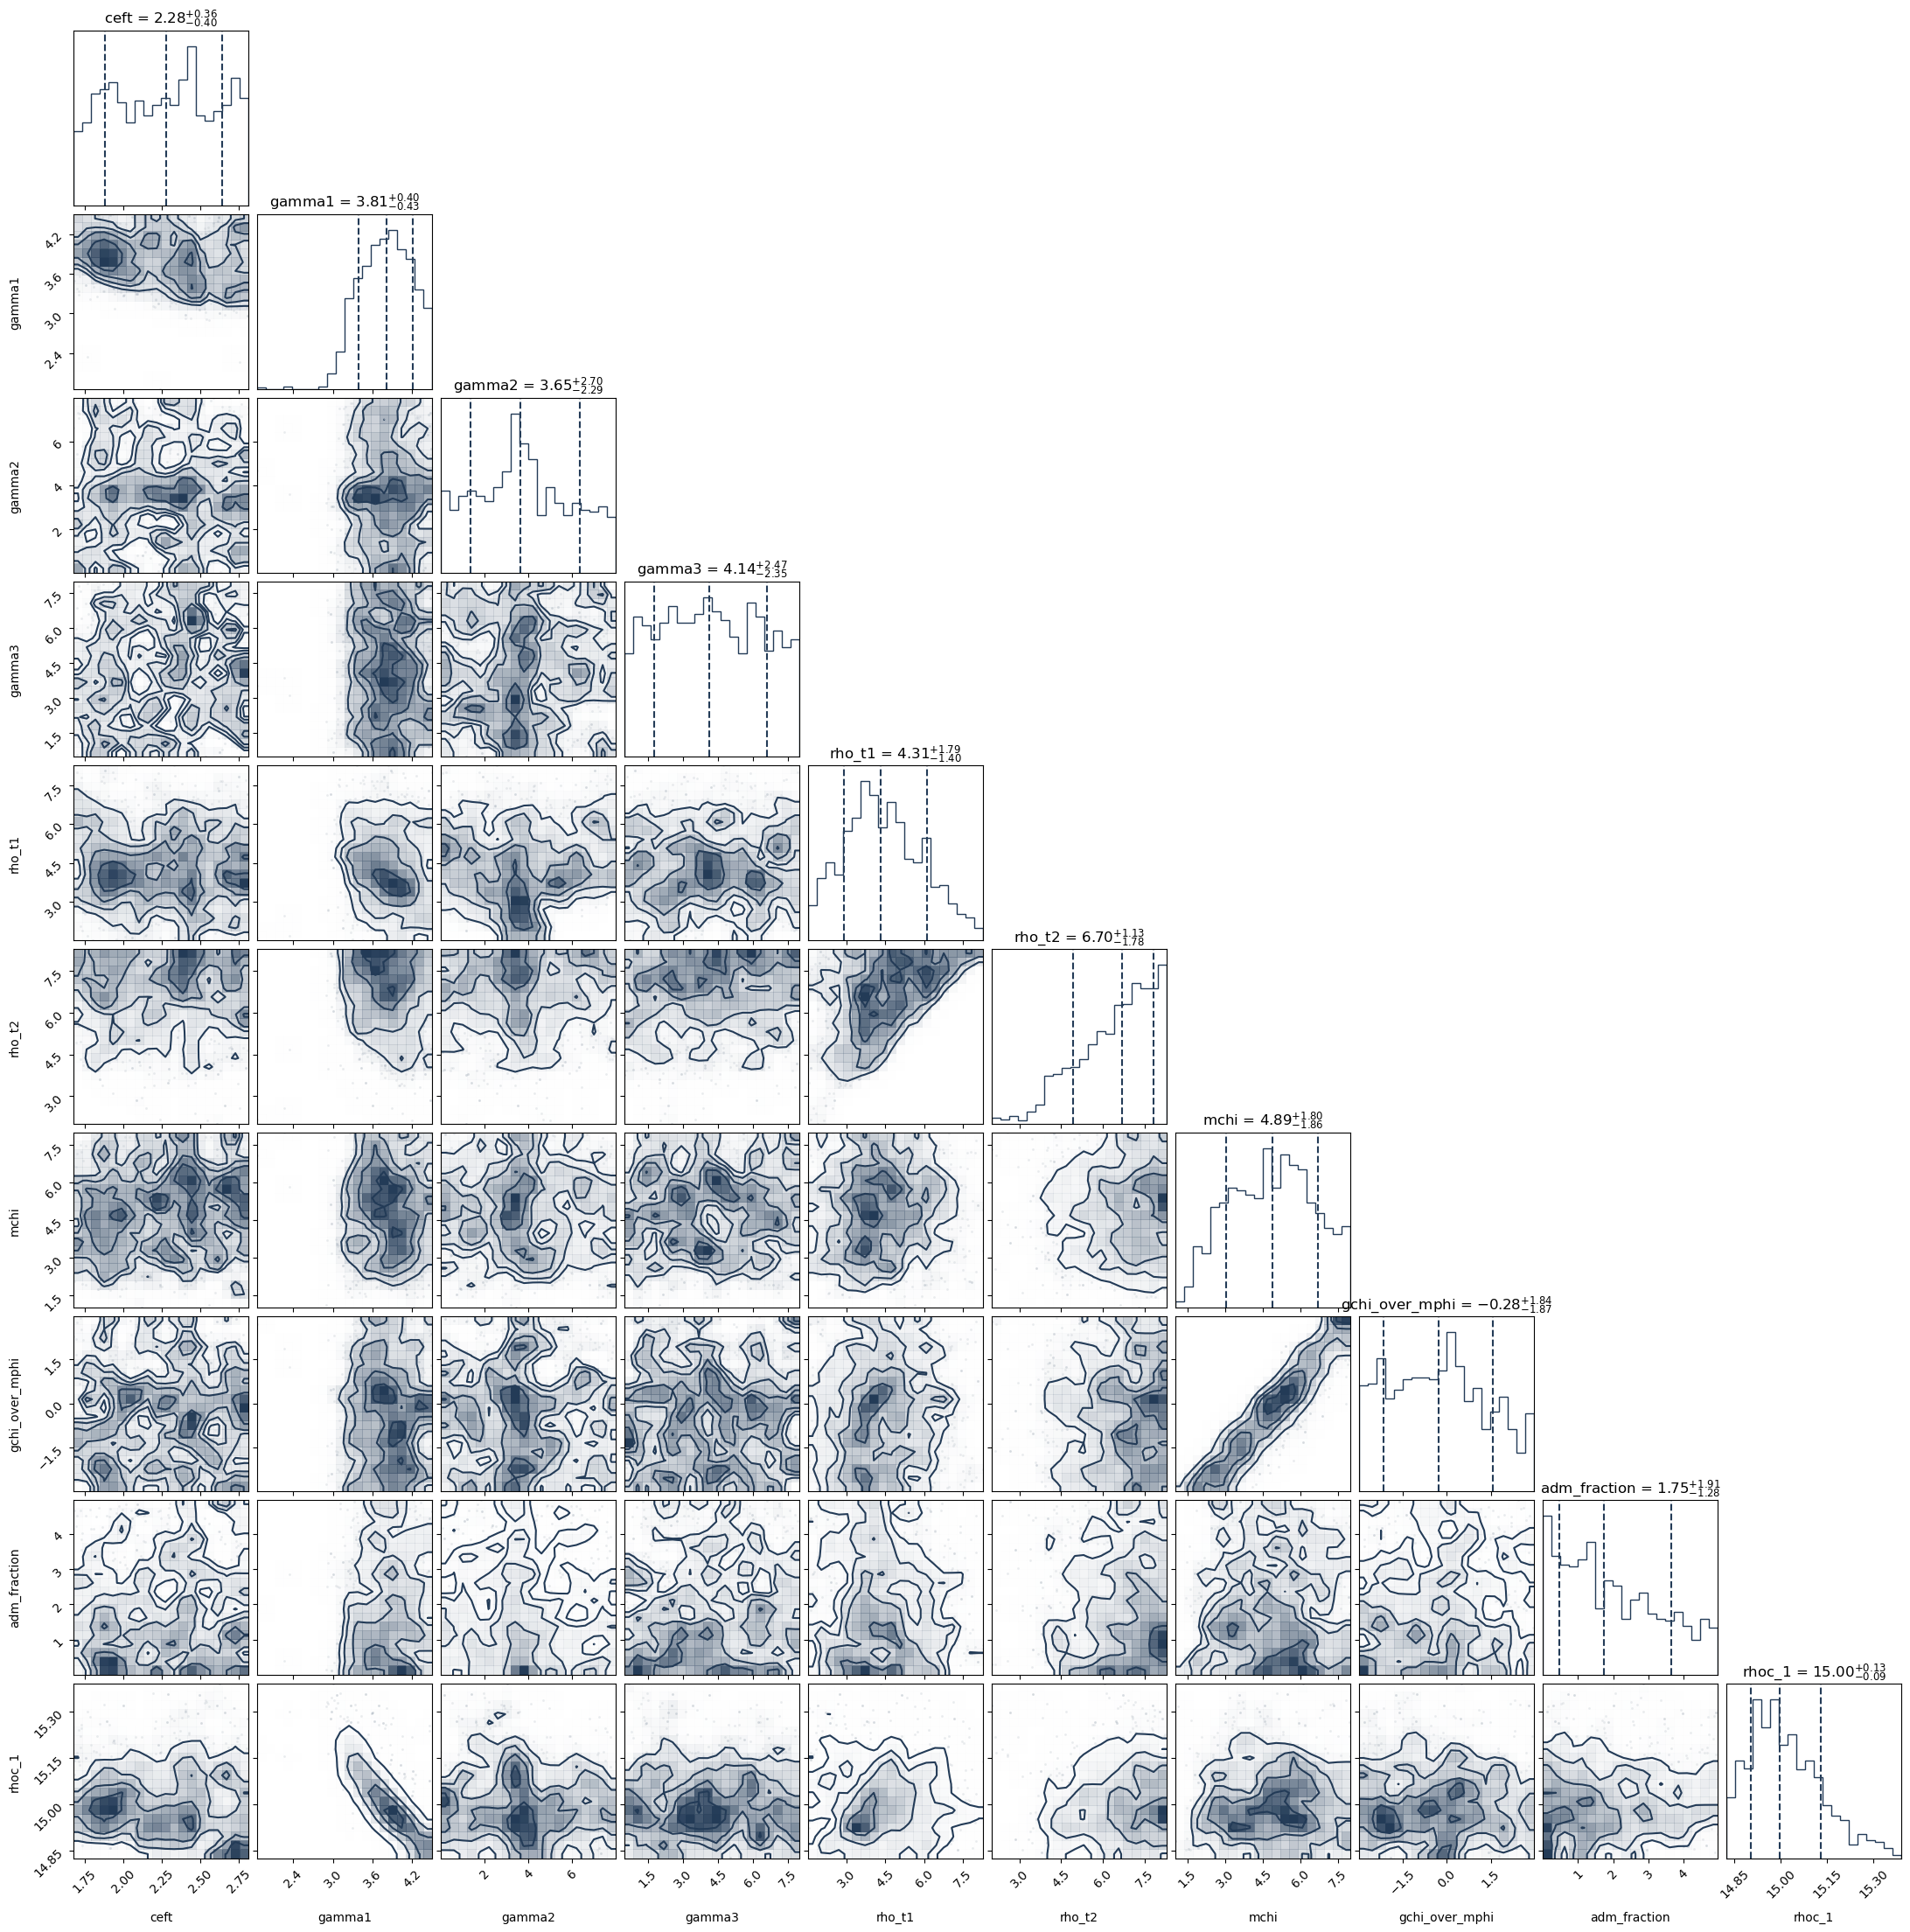

In [6]:
PosteriorAnalysis.cornerplot('chains/' + run_name, variable_params, dm = True)

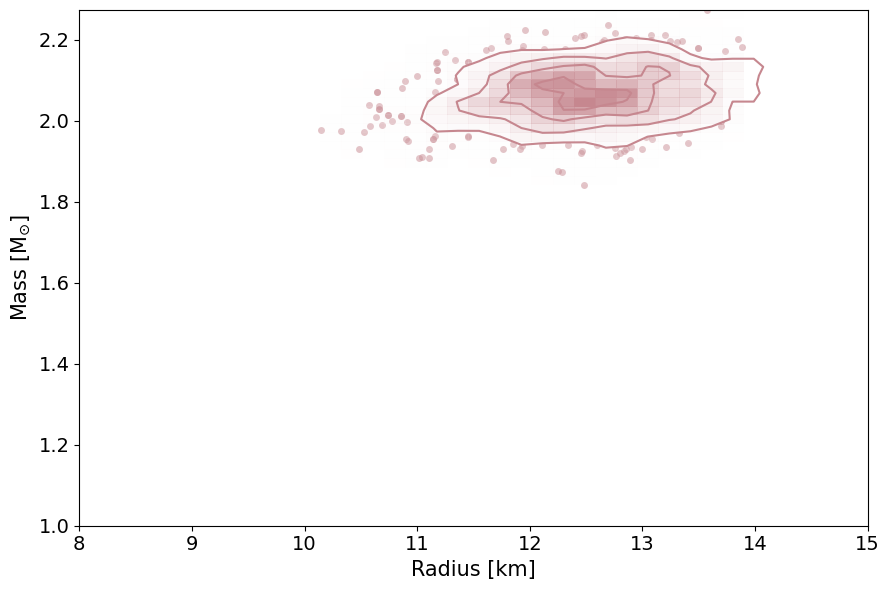

In [7]:
PosteriorAnalysis.mass_radius_posterior_plot('chains/' + run_name)

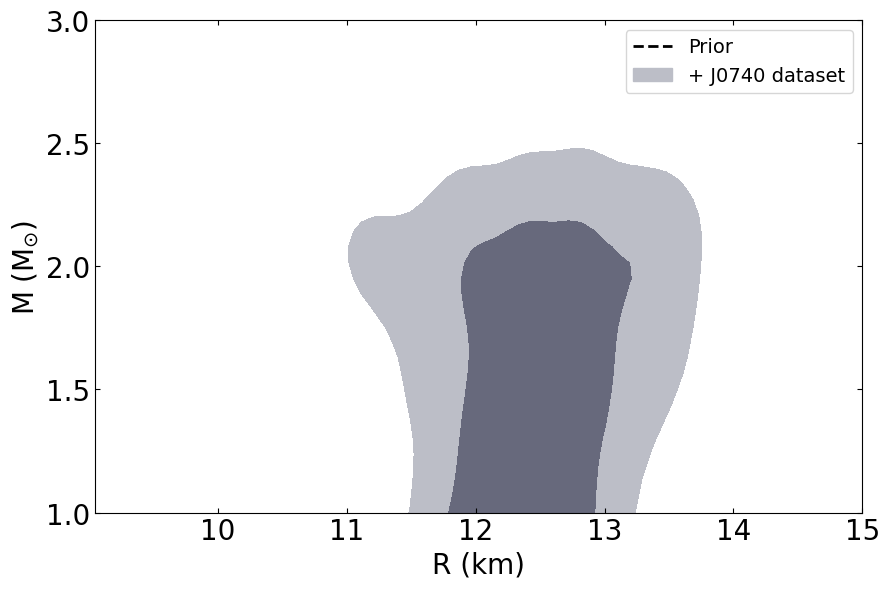

In [8]:
PosteriorAnalysis.mass_radius_prior_predictive_plot('chains/' + run_name,variable_params, label_name='+ J0740 dataset')

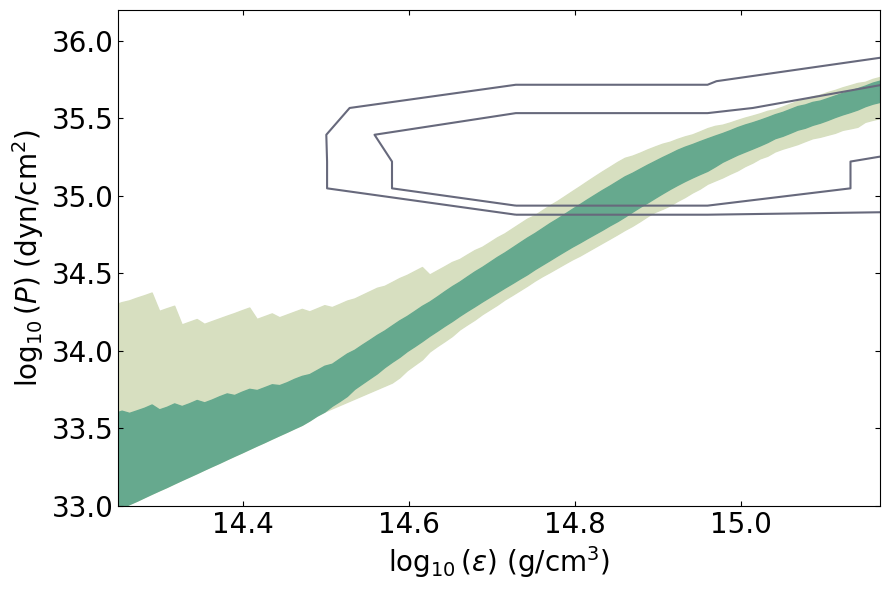

In [4]:
PosteriorAnalysis.eos_posterior_plot('chains/' + run_name, variable_params, dm = True)

Here we see that the ADM admixed EoS is very broad a lower density, which is due to the fact that the ADM pressure is comparable to the baryonic pressure within that energy density regime. Also note that posteriors are rather jagged, which is due to the low number of live point from this run.